# Time domain analysis

In [3]:
import numpy as np
import pandas as pd
loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\Discrimination\\time_perc.npz')
temp = loaded['results']
temp = np.squeeze(np.nanmean(temp, axis=1))
temp.shape

(16, 20, 100, 100, 564)

In [24]:
a = np.nanmean(temp,axis=0)[:25,:25,:]
b = np.nanmean(temp,axis=0)[25:50,25:50,:]
a = np.squeeze(np.nanmean(a,axis=(0,1)))
b = np.squeeze(np.nanmean(b,axis=(0,1)))

C:\Users\danne\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
C:\Users\danne\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


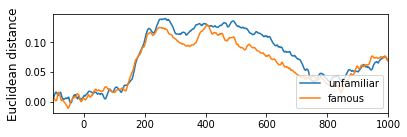

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(211)
plt.plot(np.linspace(-100,1001,564), np.squeeze(a), label='unfamiliar')
plt.plot(np.linspace(-100,1001,564), np.squeeze(b), label='famous')
plt.xlim((-100, 1000))
plt.ylabel('Euclidean distance', fontsize=12)
plt.legend(loc = 'lower right')

In [ ]:
import discr_inverted as di
%run general_tools.ipynb
%run EEG_auxiliary_module.ipynb
infolder, outfolder = find_folder()
trigs=list(range(101, 151))+list(range(201, 251))
#trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.01,45)
subs = [2]
np.random.seed(10)
n_perm = 20  # number of permutations
n_pseudo = 11  # number of pseudo-trials
results = di.compute_combined(infolder, subs, filt, im_times, event_ids, n_perm, n_pseudo)
    
    

# Importing compressed files

In [8]:
import numpy as np
import pandas as pd
loaded = np.load('pearson_no_cv.npz')
temp = loaded['result_ec']
temp = np.nanmean(temp, axis=(0,1))
a = pd.DataFrame(temp)
a

C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,0.369685,0.400576,0.455236,0.414388,0.456362,0.458469,0.474345,0.409874,0.437071,...,0.644610,0.619243,0.619380,0.611177,0.616011,0.638521,0.621384,0.648751,0.654416,0.645167
1,NaN,NaN,0.383191,0.396159,0.414168,0.436088,0.440137,0.450841,0.378934,0.391149,...,0.620916,0.592378,0.596091,0.587946,0.589196,0.611327,0.602493,0.620123,0.618518,0.629415
2,NaN,NaN,NaN,0.408048,0.422170,0.448836,0.432905,0.450176,0.400993,0.410474,...,0.638146,0.617627,0.619090,0.609959,0.600963,0.624342,0.623935,0.647649,0.641124,0.637426
3,NaN,NaN,NaN,NaN,0.438722,0.436563,0.446202,0.465324,0.400912,0.400037,...,0.621273,0.604500,0.612634,0.603743,0.593616,0.624306,0.622250,0.638010,0.626023,0.618914
4,NaN,NaN,NaN,NaN,NaN,0.365545,0.404565,0.411473,0.361072,0.402807,...,0.582509,0.547162,0.541418,0.554009,0.540979,0.555893,0.553383,0.554396,0.564226,0.571885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.276154,0.265639,0.295465,0.292698
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233880,0.260473,0.274870
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.220480,0.240336
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.242490


In [2]:
import numpy as np
import pandas as pd
loaded = np.load('pearson_no_cv.npz')
temp = loaded['result_ec']
temp.shape

(17, 20, 100, 100)

In [ ]:
import numpy as np
loaded = np.load('temp.npz')
temp = loaded['results']
temp = np.nanmean(temp, axis=1)
temp.shape
for i in range(temp.shape[0]):
    print(np.nanmean(temp[i,:25,:25]))
    

In [ ]:
import numpy as np
loaded = np.load('temp.npz')
temp1 = loaded['results']
loaded = np.load('temp2.npz')
temp3 = loaded['results']
loaded = np.load('temp1.npz')
temp2 = loaded['results']
combine_data = np.concatenate((temp1, temp2, temp3), axis=0)
combine_data.shape
np.savez_compressed('combined',results=combine_data)

In [ ]:
import numpy as np
loaded = np.load('temp.npz')
temp = loaded['results']
temp.shape

In [165]:
import discr_inverted as di
import numpy as np
infolder = 'E:\Ilya_study\Data'
trigs=list(range(101, 151))+list(range(201, 251))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.01,45)
subs = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
subs = [2]
np.random.seed(10)
n_perm = 20  # number of permutations
n_pseudo = 11  # number of pseudo-trials
results = di.compute_time(infolder, subs, filt, im_times, event_ids, n_perm, n_pseudo)

Extracting EDF parameters from E:\Ilya_study\Data\IR_02_S01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3385855  =      0.000 ...  6612.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB

2500 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2500 events and 564 original time points ...
0 bad epochs dropped
Extracting EDF parameters from E:\Ilya_study\Data\IR_02_S02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2043391  =      0.000 ...  3990.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass fi

C:\Users\danne\Documents\Codes\EEG_analysis\discr_inverted.py:792: RuntimeWarning: Mean of empty slice
  a = np.nanmean(result,axis=0)[:50,:50,:]


0.037168837747865106


In [ ]:
%run general_tools.ipynb
import
infolder, outfolder = find_folder()
trigs=list(range(101, 151))+list(range(201, 251))
#trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.03,200)
subs = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
subs = [18]
np.random.seed(10)
n_perm = 20  # number of permutations
n_pseudo = 11  # number of pseudo-trials
results = compute_time(infolder, subs, filt, im_times, event_ids)

In [11]:
%run general_tools.ipynb
%run EEG_auxiliary_module.ipynb
%run make_features.ipynb
from pathlib import Path, PurePath
import numpy as np
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import os
import scipy
from sklearn.discriminant_analysis import _cov
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
np.random.seed(10)

pick_ch=['P9','P7','P5','P3','PO7','PO3','O1','P10','P8','P6','P4','PO8','PO4','O2','POz','Pz']
#pick_ch=['PO8','PO7']

infolder, outfolder = find_folder()
trigs=list(range(101, 151))+list(range(201, 251))
#trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.03,200)
subs = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
subs = [2]

n_perm = 20  # number of permutations
n_pseudo = 11  # number of pseudo-trials

svm = SVC(kernel='linear')
CV = ShuffleBinLeaveOneOut

out = list()
for i,sub in enumerate(subs):
    update_progress(i/len(subs))
    fnames = [infolder+'\\IR_'+str(sub).zfill(2)+'_S01.bdf',infolder+'\\IR_'+str(sub).zfill(2)+'_S02.bdf']
    epochs = load_to_epochs_perc(fnames, event_ids, im_times, filt)
    epochs.drop_channels(['Status']).equalize_event_counts(event_ids=event_ids, method='mintime')
    X = epochs.get_data()
    y = epochs.events[:, 2]
    y = [a-101 if a<200 else a-151 for a in y]
    n_conditions = len(np.unique(y))
    n_sensors = X.shape[1]
    n_time = X.shape[2]
    cv = CV(y, n_iter=n_perm, n_pseudo=n_pseudo)
    result = np.full((n_perm, n_conditions, n_conditions), np.nan)
    for f, (train_indices, test_indices) in enumerate(cv.split(X)):
                print('\tPermutation %g / %g' % (f + 1, n_perm))

                # 1. Compute pseudo-trials for training and test
                Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
                Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
                for i, ind in enumerate(train_indices):
                    Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
                for i, ind in enumerate(test_indices):
                    Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


                # 2. Whitening using the Epoch method
                sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
                sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
                for k,c in enumerate(np.unique(y)):
                    # compute sigma for each time point, then average across time
                    sigma_[k] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                         for t in range(n_time)], axis=0)
                sigma = sigma_.mean(axis=0)  # average across conditions
                sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
                Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
                Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

                for c1 in range(n_conditions-1):
                    for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                            # 3. Fit the classifier using training data
                            data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, :]
                            data_train = np.reshape(data_train, (data_train.shape[0], data_train.shape[1]*data_train.shape[2]), order='F')
                            svm.fit(data_train, cv.labels_pseudo_train[c1, c2])                            

                            # 4. Compute and store classification accuracies
                            data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, :]
                            data_test = np.reshape(data_test, (data_test.shape[0], data_test.shape[1]*data_test.shape[2]), order='F')
                            result[f, c1, c2] = np.mean(svm.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5                            

        # average across permutations
    out.append(result)
    from scipy.spatial.distance import squareform
    a = np.nanmean(result,axis=0)[:50,:50]
    np.nanmean(a)

Progress: [--------------------] 0.0%
Extracting EDF parameters from E:\Ilya_study\Data\IR_02_S01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3385855  =      0.000 ...  6612.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.03 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.03, 200.00 Hz: -6.02, -6.02 dB

2500 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2500 events and 564 original time points ...
0 bad epochs dropped
Extracting EDF parameters from E:\Ilya_study\Data\IR_02_S02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2043391  =      0.000 ...  3990.998 secs...
Filtering raw data in 1 

KeyboardInterrupt: 

# Distance analysis

## No CV

In [10]:
%run general_tools.ipynb
%run EEG_auxiliary_module.ipynb
from pathlib import Path, PurePath
import numpy as np
import mne
import scipy
from sklearn.discriminant_analysis import _cov
from sklearn.svm import SVC
from dissimilarity import Euclidean2, CvEuclidean2, Pearson, CvPearson
from cv import ShuffleBinLeaveOneOut, ShuffleBin
np.random.seed(10)


infolder, outfolder = find_folder()
trigs=list(range(101, 151))+list(range(201, 251))
#trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.01,45)
subs = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

n_perm = 20  # number of permutations

ec = Euclidean2()
ec_cv = CvEuclidean2()
ps = Pearson()
ps_cv = CvPearson()

svm = SVC(kernel='linear')

out = list()
for i,sub in enumerate(subs):
    if i==0:
        n_pseudo = 11
    else: 
        n_pseudo = 12
        
    update_progress(i/len(subs))
    fnames = [infolder+'\\IR_'+str(sub).zfill(2)+'_S01.bdf',infolder+'\\IR_'+str(sub).zfill(2)+'_S02.bdf']
    epochs = load_to_epochs_perc(fnames, event_ids, im_times, filt)
    epochs.drop_channels(['Status']).equalize_event_counts(event_ids=event_ids, method='mintime')
    X = epochs.get_data()
    y = epochs.events[:, 2]
    y = [a-101 if a<200 else a-151 for a in y]
    cv = ShuffleBin(y, n_iter=n_perm, n_pseudo=n_pseudo)
    n_conditions = len(np.unique(y))
    n_sensors = X.shape[1]
    n_time = X.shape[2]
    result = np.full((n_perm, n_conditions, n_conditions), np.nan)
    for f, (train_indices, test_indices) in enumerate(cv.split(X)):
        print('\tPermutation %g / %g' % (f + 1, n_perm))

        # 1. Compute pseudo-trials for training and test
        Xpseudo = np.full((len(test_indices), n_sensors, n_time), np.nan)
        for i, ind in enumerate(test_indices):
            Xpseudo[i, :, :] = np.mean(X[ind, :, :], axis=0)
                


        # 2. Whitening using the Epoch method
        sigma_conditions = cv.labels_pseudo_test[0, :, n_pseudo:].flatten()
        sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
                
        for c in range(n_conditions):
        # compute sigma for each time point, then average across time
            sigma_[c] = np.mean([_cov(Xpseudo[sigma_conditions==c, :, t], shrinkage='auto') for t in range(n_time)], axis=0)
        sigma = sigma_.mean(axis=0)  # average across conditions
        sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
        Xpseudo = (Xpseudo.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

        for c1 in range(n_conditions-1):
            for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):                            
                    data = Xpseudo[cv.ind_pseudo_test[c1, c2], :, :]
                    data = np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]), order='F')
                    result[f, c1, c2] = ps.predict(data, y=cv.labels_pseudo_test[c1, c2])
    out.append(result)
np.savez_compressed('pearson_no_cv',results=out)

Progress: [###################-] 94.1%
Extracting EDF parameters from E:\Ilya_study\Data\IR_18_S01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3393023  =      0.000 ...  6626.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB

2500 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2500 events and 564 original time points ...
0 bad epochs dropped
Extracting EDF parameters from E:\Ilya_study\Data\IR_18_S02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3389951  =      0.000 ...  6620.998 secs...
Filtering raw data in 1 con

## with CV

In [ ]:
%run general_tools.ipynb
%run EEG_auxiliary_module.ipynb
from pathlib import Path, PurePath
import numpy as np
import mne
import scipy
from sklearn.discriminant_analysis import _cov
from sklearn.svm import SVC
from dissimilarity import Euclidean2, CvEuclidean2, Pearson, CvPearson
from cv import ShuffleBinLeaveOneOut, ShuffleBin
np.random.seed(10)


infolder, outfolder = find_folder()
trigs=list(range(101, 151))+list(range(201, 251))
#trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.01,45)
subs = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

n_perm = 20  # number of permutations

ec = Euclidean2()
ec_cv = CvEuclidean2()
ps = Pearson()
ps_cv = CvPearson()
CV = ShuffleBinLeaveOneOut
svm = SVC(kernel='linear')

out_ec = list()
out_pc = list()
for i,sub in enumerate(subs):
    if i==0:
        n_pseudo = 11
    else: 
        n_pseudo = 12
        
    update_progress(i/len(subs))
    fnames = [infolder+'\\IR_'+str(sub).zfill(2)+'_S01.bdf',infolder+'\\IR_'+str(sub).zfill(2)+'_S02.bdf']
    epochs = load_to_epochs_perc(fnames, event_ids, im_times, filt)
    epochs.drop_channels(['Status']).equalize_event_counts(event_ids=event_ids, method='mintime')
    X = epochs.get_data()
    y = epochs.events[:, 2]
    y = [a-101 if a<200 else a-151 for a in y]
    cv = CV(y, n_iter=n_perm, n_pseudo=n_pseudo)
    n_conditions = len(np.unique(y))
    n_sensors = X.shape[1]
    n_time = X.shape[2]
    result_ec = np.full((n_perm, n_conditions, n_conditions), np.nan)
    result_ps = np.full((n_perm, n_conditions, n_conditions), np.nan)
    for f, (train_indices, test_indices) in enumerate(cv.split(X)):
        print('\tPermutation %g / %g' % (f + 1, n_perm))

        # 1. Compute pseudo-trials for training and test
        Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
        Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
        for i, ind in enumerate(train_indices):
            Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
        for i, ind in enumerate(test_indices):
            Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


        # 2. Whitening using the Epoch method
        sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
        sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
        for k,c in enumerate(np.unique(y)):
            # compute sigma for each time point, then average across time
            sigma_[k] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                         for t in range(n_time)], axis=0)
        sigma = sigma_.mean(axis=0)  # average across conditions
        sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
        Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
        Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

        for c1 in range(n_conditions-1):
            for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):                        
                data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, :]
                data_train = np.reshape(data_train, (data_train.shape[0], data_train.shape[1]*data_train.shape[2]), order='F')
                ec_cv.fit(data_train, cv.labels_pseudo_train[c1, c2])                            
                ps_cv.fit(data_train, cv.labels_pseudo_train[c1, c2])
                
                data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, :] 
                data_test = np.reshape(data_test, (data_test.shape[0], data_test.shape[1]*data_test.shape[2]), order='F')
                
                result_ec[f, c1, c2] = ec_cv.predict(data_test, y=cv.labels_pseudo_test[c1, c2])
                result_ps[f, c1, c2] = ps_cv.predict(data_test, y=cv.labels_pseudo_test[c1, c2])
    out_ec.append(result_ec)
    out_pc.append(result_ps)
np.savez_compressed('distance_with_cv',result_ec=out_ec, result_pc=out_pc)

Progress: [##################--] 88.2%
Extracting EDF parameters from E:\Ilya_study\Data\IR_17_S01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3389439  =      0.000 ...  6619.998 secs...


In [14]:
data_train.shape

(2, 36096)

In [2]:
from dissimilarity import Euclidean2, CvEuclidean2, Pearson, CvPearson

In [ ]:
np.savez_compressed('acc_perc_all',results=out)

In [ ]:
out = list()
out.append(result)
for i in results:
    out.append(i)
len(out)

In [2]:
import numpy as np
loaded = np.load('temp_11.npz')
results = loaded['results']
results.shape

(1, 20, 100, 100, 564)

In [ ]:
for i in out:
    print(np.nanmean(i[:,:25,:25]))

In [ ]:
%run general_tools.ipynb
%run EEG_auxiliary_module.ipynb
%run make_features.ipynb
from pathlib import Path, PurePath
import numpy as np
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
np.random.seed(10)

pick_ch=['P9','P7','P5','P3','PO7','PO3','O1','P10','P8','P6','P4','PO8','PO4','O2','POz','Pz']
#pick_ch=['PO8','PO7']

infolder, outfolder = find_folder()
trigs=list(range(101, 151))+list(range(201, 251))
#trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.03,200)
fnames = ['E:\\Ilya_study\\Data\\IR_06_S01.bdf','E:\\Ilya_study\\Data\\IR_06_S02.bdf']
epochs = load_to_epochs_perc(fnames, event_ids, im_times, filt)
epochs.drop_channels(['Status']).equalize_event_counts(event_ids=event_ids, method='mintime')
#epochs = block_average(epochs,4,12, kind='perc',zscore = False)
pick_ch = mne.pick_channels(epochs.ch_names, pick_ch)
#data = epochs.get_data()[:, pick_ch, :]
X = epochs.get_data()
y = epochs.events[:, 2]
y = [a-101 if a<200 else a-151 for a in y]

In [ ]:
np.unique(y)

In [ ]:
import os

import numpy as np
import scipy
from sklearn.discriminant_analysis import _cov
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Parameters
n_perm = 20  # number of permutations
n_pseudo = 12  # number of pseudo-trials
n_conditions = len(np.unique(y))
n_sensors = X.shape[1]
n_time = X.shape[2]

In [ ]:
svm = SVC(kernel='linear')
CV = ShuffleBinLeaveOneOut
cv = CV(y, n_iter=n_perm, n_pseudo=n_pseudo)
result = np.full((n_perm, n_conditions, n_conditions, n_time), np.nan)

In [ ]:
for f, (train_indices, test_indices) in enumerate(cv.split(X)):
            print('\tPermutation %g / %g' % (f + 1, n_perm))

            # 1. Compute pseudo-trials for training and test
            Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
            Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
            for i, ind in enumerate(train_indices):
                Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
            for i, ind in enumerate(test_indices):
                Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


            # 2. Whitening using the Epoch method
            sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
            sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
            for k,c in enumerate(np.unique(y)):
                # compute sigma for each time point, then average across time
                sigma_[k] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                     for t in range(n_time)], axis=0)
            sigma = sigma_.mean(axis=0)  # average across conditions
            sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
            Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
            Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

            for t in range(n_time):
                for c1 in range(n_conditions-1):
                    for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                            # 3. Fit the classifier using training data
                            data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, t]
                            svm.fit(data_train, cv.labels_pseudo_train[c1, c2])                            

                            # 4. Compute and store classification accuracies
                            data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, t]
                            result[f, c1, c2, t] = np.mean(svm.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5                            
                           
    # average across permutations

       

In [ ]:
np.save( 'cum_accuracy_06.npy', result)

In [ ]:
temp = np.load('C:\\Users\\danne\\Documents\Codes\\EEG_analysis\\result_decoding_time.npy')
temp.shape

In [ ]:
temp = np.load('C:\\Users\\danne\\Documents\Codes\\EEG_analysis\\result_decoding_time.npy')
temp1 = np.nanmean(temp[:,:25,:25,:], axis=(0,1,2))
temp2 = np.nanmean(temp[:,25:50,25:50,:], axis=(0,1,2))
temp.shape
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.linspace(-100,1000,564),temp1, label='unfamiliar')
plt.plot(np.linspace(-100,1000,564),temp2, label='famous')
plt.legend()
plt.savefig('sub6.png')

In [ ]:
result = np.full((n_perm, n_conditions, n_conditions), np.nan)
for f, (train_indices, test_indices) in enumerate(cv.split(X)):
            print('\tPermutation %g / %g' % (f + 1, n_perm))

            # 1. Compute pseudo-trials for training and test
            Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
            Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
            for i, ind in enumerate(train_indices):
                Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
            for i, ind in enumerate(test_indices):
                Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


            # 2. Whitening using the Epoch method
            sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
            sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
            for k,c in enumerate(np.unique(y)):
                # compute sigma for each time point, then average across time
                sigma_[k] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                     for t in range(n_time)], axis=0)
            sigma = sigma_.mean(axis=0)  # average across conditions
            sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
            Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
            Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

            for c1 in range(n_conditions-1):
                for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                        # 3. Fit the classifier using training data
                        data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, :]
                        data_train = np.reshape(data_train, (data_train.shape[0], data_train.shape[1]*data_train.shape[2]), order='F')
                        svm.fit(data_train, cv.labels_pseudo_train[c1, c2])                            

                        # 4. Compute and store classification accuracies
                        data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, :]
                        data_test = np.reshape(data_test, (data_test.shape[0], data_test.shape[1]*data_test.shape[2]), order='F')
                        result[f, c1, c2] = np.mean(svm.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5                            
                           
    # average across permutations
from scipy.spatial.distance import squareform
a = np.nanmean(result,axis=0)[:50,:50]
np.nanmean(a)

In [ ]:
np.nanmean(result[7,:10,:10])

We set a seed, in order to make analyses reproducible:

Let's load some data:

In [ ]:
root = '' # This is the /path/to the directory containing the data.
          # We leave it empty here, because the data is located in the current directory.

# Load data and trial labels for the two sessions of participant 01
sessions = [
    # Session 1
    dict(
        data=np.load(os.path.join(root, 'data01_sess1.npy')),
        # data has shape n_trials x n_sensors x n_timepoints
        labels=np.load(os.path.join(root, 'labels01_sess1.npy'))
        # labels has shape 1 x n_trials (i.e., one condition label [object category] per trial)
    ),
    # Session 2
    dict(
        data=np.load(os.path.join(root, 'data01_sess2.npy')),
        labels=np.load(os.path.join(root, 'labels01_sess2.npy'))
    )
]

Now we set some parameters. Only the number of permutations and the number of pseudo-trials are free parameters. The number of conditions, sensors, time points and sessions are derived from the data (i.e., from the `sessions` variable above).

In [ ]:

n_sessions = len(sessions)

We define three classifiers that will be compared: Support Vector Machine, Gaussian Naive Bayes and the [Weighted Robust Distance](https://github.com/m-guggenmos/weird). We provide the code for Linear Discriminant Analysis only in comments, as it is quite slow in this scikit-learn Python implementation.

In [ ]:

gnb = GaussianNB()
weird = WeiRD()
# lda = LDA(sigma=np.eye(n_sensors))  # passing identitity covariance matrix to LDA, since data is pre-whitened

We choose our partitioning scheme, here `ShuffleBinLeaveOneOut`. This class will provide the trial-to-pseudo-trial assignments for each permutation. We'll define the class object already at this point:

In [ ]:
# Choose data partitioning scheme


The analytic logic is contained in a nested for loop, with loops for the number of sessions, number of permutations, number of timepoints, number of conditions, and number of conditions again. Overall, the logic contains 4 crucial steps:
1. Compute pseudo-trials for the training and test data
2. Whiten the training data (here using the Epoch method, which is recommended in our manuscript)
3. Fit the classifier to the training data
4. Compute classification accuracy on test data

In [ ]:
# pre-load mechanism, for convenience
preload_result = True # for recomputing the decoding analyses, set to False
if preload_result:
    result = np.load(os.path.join(root, 'result_decoding.npy'))
else:
    result = np.full((n_sessions, n_perm, n_conditions, n_conditions, n_time), np.nan,
                     dtype={'names': ['svm', 'gnb', 'weird', 'lda'], 'formats': 4*['f8']})

    for s, session in enumerate(sessions):

        print('Session %g / %g' % (s + 1, n_sessions))

        X = session['data']
        y = session['labels']

        cv = CV(y, n_iter=n_perm, n_pseudo=n_pseudo)

        for f, (train_indices, test_indices) in enumerate(cv.split(X)):
            print('\tPermutation %g / %g' % (f + 1, n_perm))

            # 1. Compute pseudo-trials for training and test
            Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
            Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
            for i, ind in enumerate(train_indices):
                Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
            for i, ind in enumerate(test_indices):
                Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


            # 2. Whitening using the Epoch method
            sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
            sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
            for c in range(n_conditions):
                # compute sigma for each time point, then average across time
                sigma_[c] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                     for t in range(n_time)], axis=0)
            sigma = sigma_.mean(axis=0)  # average across conditions
            sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
            Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
            Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

            for t in range(n_time):
                for c1 in range(n_conditions-1):
                    for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                            # 3. Fit the classifier using training data
                            data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, t]
                            svm.fit(data_train, cv.labels_pseudo_train[c1, c2])                            
                            gnb.fit(data_train, cv.labels_pseudo_train[c1, c2])
                            weird.fit(data_train, cv.labels_pseudo_train[c1, c2])
                            # lda.fit(data_train, cv.labels_pseudo_train[c1, c2])

                            # 4. Compute and store classification accuracies
                            data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, t]
                            result['svm'][s, f, c1, c2, t] = np.mean(svm.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5                            
                            result['gnb'][s, f, c1, c2, t] = np.mean(gnb.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5
                            result['weird'][s, f, c1, c2, t] = np.mean(weird.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5
                            # result['lda'][s, f, c1, c2, t] = np.mean(lda.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5
    # average across permutations
    result_ = np.full((n_sessions, n_conditions, n_conditions, n_time), np.nan,
                      dtype={'names': ['svm', 'gnb', 'weird', 'lda'], 'formats': 4*['f8']})    
    result_['svm'] = np.nanmean(result['svm'], axis=1)
    result_['gnb'] = np.nanmean(result['gnb'], axis=1)
    result_['weird'] = np.nanmean(result['weird'], axis=1)
    # result_['lda'] = np.nanmean(result['lda'], axis=1)
    result = result_
    np.save(os.path.join(root, 'result_decoding.npy'), result)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Now we plot the average classification accuracy time course by collapsing across sessions and conditions:

In [ ]:
plt.plot(np.arange(-100, 1001, 10), 100*np.nanmean(result['svm'], axis=(0, 1, 2))+50, label='SVM')
plt.plot(np.arange(-100, 1001, 10), 100*np.nanmean(result['gnb'], axis=(0, 1, 2))+50, label='GNB')
plt.plot(np.arange(-100, 1001, 10), 100*np.nanmean(result['weird'], axis=(0, 1, 2))+50, label='WeiRD')
if 'lda' in result.dtype.names:
    plt.plot(np.arange(-100, 1001, 10), 100*np.nanmean(result['lda'], axis=(0, 1, 2))+50, label='LDA')
plt.plot([-100, 1000], [50, 50], 'k-')
plt.xlim((-100, 1000))
plt.xlabel('Time [ms]', fontsize=15)
plt.ylabel('Classification accuracy', fontsize=15)
plt.legend()

# Correlations

## Corellation of new accuracies with old accuracies

In [20]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from scipy.stats import pearsonr
%run general_tools.ipynb
%run EEG_auxiliary_module.ipynb

infolder, outfolder = find_folder()
data = load_pkl(outfolder, 'svm_prc_accuracy.pkl')
data_old = np.squeeze(np.array(data))
data_old = squareform(data_old[:50,:50])

loaded = np.load('E:\\Ilya_study\\Confusion matrices\\combined.npz')
temp = loaded['results']
temp = np.nanmean(temp, axis=(0,1))
data_new = np.squeeze(squareform(squareform(temp, checks=False)))
data_new = squareform(data_new[:50,:50])

out = pearsonr(data_old,data_new)
out

C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


(-0.05965992795586425, 0.036813566889765156)

## Correlation of new accuracies with theoeretical observer

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from scipy.stats import pearsonr
%run general_tools.ipynb
%run EEG_auxiliary_module.ipynb


stims = pd.read_csv('C:\\Users\\danne\\Dropbox\\Ilya_study\\Stimuli\\stims.csv')
descr = pd.read_csv('C:\\Users\\danne\\Dropbox\\Ilya_study\\Analysis\\description.csv', index_col = 'Nums') # loading origin desription
dist = pdist(stims.T)

loaded = np.load('E:\\Ilya_study\\Confusion matrices\\combined.npz')
temp = loaded['results']
temp = np.nanmean(temp, axis=(0,1))
data_new = np.squeeze(squareform(squareform(temp, checks=False)))
data_new = squareform(data_new[:50,:50])

out = pearsonr(dist,data_new)
out


C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


ValueError: x and y must have the same length.

## Correlation of old accuracies with TO

In [23]:
out = pearsonr(dist,data_old)
out

(-0.01450476444235551, 0.6120319194925341)

## Correlations between participants in new results

In [16]:
dist.shape

(50, 50)

In [5]:
outfolder


'E:\\Ilya_study\\Analysis'

In [ ]:
# Imagery analysis

# Familiarity analysis

## Importing data

In [13]:
from pathlib import Path
import numpy as np
folder = r'C:\Users\danne\Documents\UofT\ImRecon'
fileName = r'time_perc.npz'
path = Path(folder)/fileName
loaded = np.load(path)
temp = loaded['results']
temp = np.squeeze(np.nanmean(temp, axis=1))
unf = np.nanmean(temp,axis=0)[:25,:25,:]
fam = np.nanmean(temp,axis=0)[25:50,25:50,:]
unf = np.squeeze(np.nanmean(unf,axis=(0,1)))
fam = np.squeeze(np.nanmean(fam,axis=(0,1)))

C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [18]:
cross1 = np.nanmean(temp[:,:25,25:50,:],axis=(1,2))
cross2 = np.nanmean(temp[:,25:50,:25,:],axis=(1,2))
cross = np.nanmean( np.array([ cross1, cross2 ]), axis=0 )
cross.shape

C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


(17, 564)

## Inferential statisitcs

In [9]:
import numpy as np
loaded = np.load(path)
temp = loaded['results']
fams = np.nanmean(temp[:,:,25:50,25:50,:], axis=(1,2,3))
unfr = np.nanmean(temp[:,:,:25,:25,:], axis=(1,2,3))


In [19]:
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection as fdr
out_2 = stats.ttest_ind(fams,unfr,0)
print(any(fdr(out_2[1], alpha = 0.05)[0]))
out_fam = stats.ttest_1samp(fams,0,axis=0)
out_fam = fdr(out_fam[1], alpha = 0.05)
out_unf = stats.ttest_1samp(unfr,0,axis=0)
out_unf = fdr(out_unf[1], alpha = 0.05)
out_cross = stats.ttest_1samp(cross,0,axis=0)
out_cross = fdr(out_cross[1], alpha = 0.05)

False


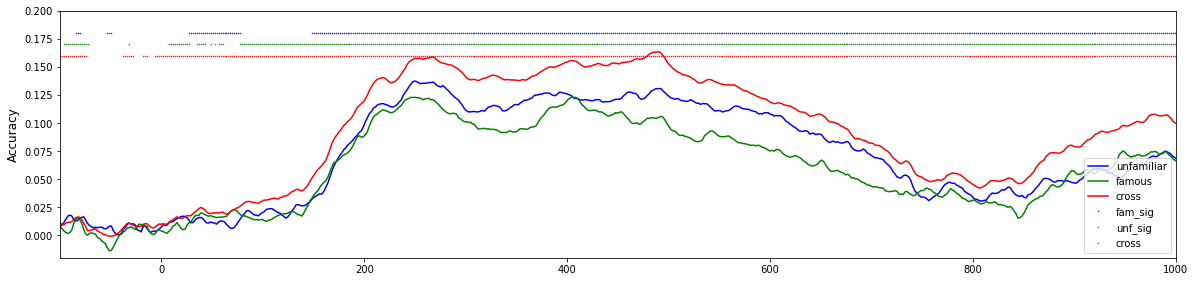

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(np.linspace(-100,1001,564), np.squeeze(unf), 'b', label='unfamiliar')
plt.plot(np.linspace(-100,1001,564), np.squeeze(fam), 'g', label='famous')
plt.plot(np.linspace(-100,1001,564), np.squeeze(np.mean(cross,axis=0)), 'r', label='cross')
plt.plot(np.linspace(-100,1001,564), out_fam[0]*1-0.82,'b.', markersize = 1, label='fam_sig')
plt.plot(np.linspace(-100,1001,564), out_unf[0]*1-0.83, 'g.', markersize = 1, label='unf_sig')
plt.plot(np.linspace(-100,1001,564), out_cross[0]*1-0.84, 'r.', markersize = 1, label='cross')
plt.xlim((-100, 1000))
plt.ylim((-0.02,0.2))
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc = 'lower right')

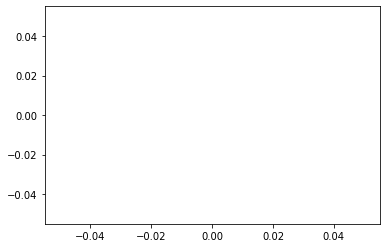

In [17]:
plt.plot(np.mean(cross,axis=0))

# Familiarity discrimination
Train 24 test on 25th

In [ ]:
import discr_inverted as di
import numpy as np
import mne
from sklearn.discriminant_analysis import _cov    
import scipy
from sklearn.svm import SVC

infolder = 'E:\Ilya_study\Data'
out = list()
trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.01,45)
subs = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
np.random.seed(10)
n_perm = 20  # number of permutations
n_pseudo = 12  # number of pseudo-trials
baseline = (None, 0)
stims = np.arange(len(trigs))
n_stims = len(trigs)
half = int(n_stims/2)
y = [1]*half+[2]*half
svm = SVC(kernel='linear')
for i,sub in enumerate(subs):
    fnames = [infolder+'/IR_'+str(sub).zfill(2)+'_S01.bdf',infolder+'/IR_'+str(sub).zfill(2)+'_S02.bdf']
    epochs = []
    for fname in fnames:
        raw = mne.io.read_raw_bdf(fname, preload=True).filter(filt[0], filt[1], method='iir')
        events = mne.find_events(raw, initial_event=True, 
                                consecutive=True, shortest_event=1, verbose=0)
        temp = mne.Epochs(raw, events, event_ids, im_times[0], im_times[1],
                         baseline=baseline, preload=True, detrend = 1)
        epochs.append(temp)
    epochs = mne.concatenate_epochs(epochs)
    epochs.drop_channels(['Status']).equalize_event_counts(event_ids=event_ids, method='mintime')
    X = [epochs[str(i)].average().data for i in np.unique(trigs)]
    X = np.array(X)
    pairs = list(zip(np.random.permutation(half),np.random.permutation(half)+half))
    n_sensors = X.shape[1]
    n_conditions = np.unique(y).shape[0]
    n_time = X.shape[2]
    result = np.full((len(pairs),n_time), np.nan)
    for inx, tests in enumerate(pairs):
        test_indices = np.where(np.logical_or(stims == pairs[inx][0], stims == pairs[inx][1]))[0]
        train_indices = np.where(np.logical_not(np.logical_or(stims == pairs[inx][0], stims == pairs[inx][1])))[0]
        temp = y.copy()
        temp.pop(pairs[inx][0])
        temp.pop(pairs[inx][1]-1)
        Xpseudo_train = X[train_indices,:,:]
        Xpseudo_test = X[test_indices,:,:]
#         sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
#         for k,c in enumerate(np.unique(y)):
#                 # compute sigma for each time point, then average across time
#             sigma_[k] = np.mean([_cov(Xpseudo_train[temp==c, :, t], shrinkage='auto')
#                                              for t in range(n_time)], axis=0)
#         sigma = sigma_.mean(axis=0)  # average across conditions
#         sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
#         Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
#         Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
        for t in range(n_time):
                            # 3. Fit the classifier using training data
            data_train = Xpseudo_train[:, :, t]
            svm.fit(data_train, temp)                            
            data_test = Xpseudo_test[:, :, t]
            result[inx, t] = np.mean(svm.predict(data_test) == [1,2]) - 0.5 
    out.append(result)
    np.savez_compressed('temp',results=out)
np.savez_compressed('fam_time',results=out)

        
        
       
        
        

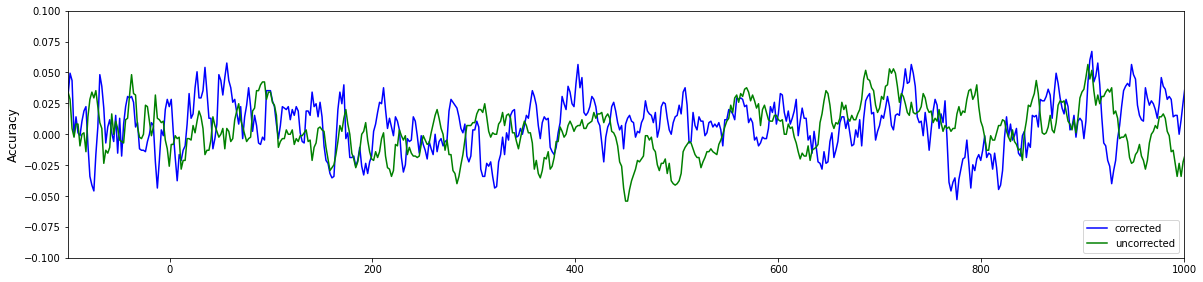

In [14]:
import numpy as np
loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\ImRecon\\fam_time.npz')
corr = loaded['results']
loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\ImRecon\\fam_time_no_correction.npz')
nocor = loaded['results']


import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(np.linspace(-100,1001,564), np.mean(corr, axis=(0,1)), 'b', label='corrected')
plt.plot(np.linspace(-100,1001,564), np.mean(nocor, axis=(0,1)), 'g', label='uncorrected')
plt.xlim((-100, 1000))
plt.ylim((-0.1,0.1))
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc = 'lower right')

# Correlations between imagery and perception

In [9]:
%run EEG_auxiliary_module.ipynb
import numpy as np
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\ImRecon\\combined.npz')
perc = loaded['results']
loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\ImRecon\\imagery_combined.npz')
imag_5 = loaded['results']
perc = np.nanmean(perc,axis=1)
perc = [isolate_perc_5(perc[i,:50,:50]) for i in range(perc.shape[0])]
perc = np.array(perc)
imag_5 = np.nanmean(imag_5,axis=1)
a = np.nanmean(perc,axis=(0))
b = np.nanmean(imag_5,axis=(0))
a = a[~np.isnan(a)]
b = b[~np.isnan(b)]
print("Accuracy for the 5-seconds inbterval is %f" %(np.nanmean(imag_5)))

C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


Accuracy for the 5-seconds inbterval is 0.101471


C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


## Interpersonal correaltion perception X imagery 5 seconds

In [34]:
pearsonr(np.nanmean(perc,axis=(1,2)),np.nanmean(imag_5,axis=(1,2)))

(0.17474642729548248, 0.5023423564875313)

## Inter-item correlation perception X imagery 5 seconds

In [49]:
pearsonr(a,b)

(0.6265022720830651, 0.05260170917739324)

In [11]:
%run EEG_auxiliary_module.ipynb
import numpy as np
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\ImRecon\\combined.npz')
perc = loaded['results']
loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\ImRecon\\imagery_combined_2sec.npz')
imag_2 = loaded['results']
perc = np.nanmean(perc,axis=1)
perc = [isolate_perc_5(perc[i,:50,:50]) for i in range(perc.shape[0])]
perc = np.array(perc)
imag_2 = np.nanmean(imag_2,axis=1)
a = np.nanmean(perc,axis=(0))
b = np.nanmean(imag_2,axis=(0))
a = a[~np.isnan(a)]
b = b[~np.isnan(b)]
print("Accuracy for the 2-seconds inbterval is %f" %(np.nanmean(imag_2)))

C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


Accuracy for the 2-seconds inbterval is 0.097500


C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


## Interpersonal correaltion perception X imagery 2 seconds

In [6]:
pearsonr(np.nanmean(perc,axis=(1,2)),np.nanmean(imag_5,axis=(1,2)))

(0.16247904736409324, 0.5332496356620995)

## Inter-item correlation perception X imagery 2 seconds

In [8]:
pearsonr(a,b)

(0.4623577661054852, 0.1784847338649811)

In [12]:
np.nanmean(perc)

0.11132352941176471

# Computing normalized cumulative familiarity

In [14]:
import discr_inverted as di
import numpy as np
import mne
from sklearn.discriminant_analysis import _cov    
import scipy
from sklearn.svm import SVC

infolder = 'E:\Ilya_study\Data'
out = list()
trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.01,45)
subs = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
np.random.seed(10)
n_perm = 20  # number of permutations
n_pseudo = 12  # number of pseudo-trials
baseline = (None, 0)
stims = np.arange(len(trigs))
n_stims = len(trigs)
half = int(n_stims/2)
y = [1]*half+[2]*half
svm = SVC(kernel='linear')
for i,sub in enumerate(subs):
    fnames = [infolder+'/IR_'+str(sub).zfill(2)+'_S01.bdf',infolder+'/IR_'+str(sub).zfill(2)+'_S02.bdf']
    epochs = []
    for fname in fnames:
        raw = mne.io.read_raw_bdf(fname, preload=True).filter(filt[0], filt[1], method='iir')
        events = mne.find_events(raw, initial_event=True, 
                                consecutive=True, shortest_event=1, verbose=0)
        temp = mne.Epochs(raw, events, event_ids, im_times[0], im_times[1],
                         baseline=baseline, preload=True, detrend = 1)
        epochs.append(temp)
    epochs = mne.concatenate_epochs(epochs)
    epochs.drop_channels(['Status']).equalize_event_counts(event_ids=event_ids, method='mintime')
    X = [epochs[str(i)].average().data for i in np.unique(trigs)]
    X = np.array(X)
    X = X[:,:,75:384] # selecting 50 to 650 ms.
    pairs = list(zip(np.random.permutation(half),np.random.permutation(half)+half))
    n_sensors = X.shape[1]
    n_conditions = np.unique(y).shape[0]
    n_time = X.shape[2]
    result = np.full((len(pairs)), np.nan)
    for inx, tests in enumerate(pairs):
        test_indices = np.where(np.logical_or(stims == pairs[inx][0], stims == pairs[inx][1]))[0]
        train_indices = np.where(np.logical_not(np.logical_or(stims == pairs[inx][0], stims == pairs[inx][1])))[0]
        temp = y.copy()
        temp.pop(pairs[inx][0])
        temp.pop(pairs[inx][1]-1)
        Xpseudo_train = X[train_indices,:,:]
        Xpseudo_test = X[test_indices,:,:]
        sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
        for k,c in enumerate(np.unique(y)):
                # compute sigma for each time point, then average across time
            sigma_[k] = np.mean([_cov(Xpseudo_train[temp==c, :, t], shrinkage='auto')
                                             for t in range(n_time)], axis=0)
        sigma = sigma_.mean(axis=0)  # average across conditions
        sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
        Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
        Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
        Xpseudo_train = np.reshape(Xpseudo_train, (Xpseudo_train.shape[0], Xpseudo_train.shape[1]*Xpseudo_train.shape[2]), order='F')
        svm.fit(Xpseudo_train, temp)                            
        Xpseudo_test = np.reshape(Xpseudo_test, (Xpseudo_test.shape[0], Xpseudo_test.shape[1]*Xpseudo_test.shape[2]), order='F')
        result[inx] = np.mean(svm.predict(Xpseudo_test) == [1,2]) - 0.5 
    out.append(result)
    np.savez_compressed('temp',results=out)
out = np.array(out)
np.savez_compressed('fam_cumul',results=out)


Extracting EDF parameters from E:\Ilya_study\Data\IR_02_S01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3385855  =      0.000 ...  6612.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB

1250 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1250 events and 564 original time points ...
0 bad epochs dropped
Extracting EDF parameters from E:\Ilya_study\Data\IR_02_S02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2043391  =      0.000 ...  3990.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass fi

In [17]:
np.nanmean(out)

0.011764705882352941

# T-test for inter-item correlations

In [23]:
%run EEG_auxiliary_module.ipynb
import numpy as np
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\ImRecon\\combined.npz')
perc = loaded['results']
loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\ImRecon\\imagery_combined.npz')
imag_5 = loaded['results']
perc = np.nanmean(perc,axis=1)
perc = [isolate_perc_5(perc[i,:50,:50]) for i in range(perc.shape[0])]
perc = np.array(perc)
imag_5 = np.nanmean(imag_5, axis=1)
corrs = list()
for i in range(imag_5.shape[0]):
    temp = imag_5[i,:,:]
    corr_a = temp[~np.isnan(temp)]
    temp = perc[i,:,:]
    corr_b = temp[~np.isnan(temp)]
    corrs.append(pearsonr(corr_a,corr_b)[0])

C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


In [44]:
from scipy import stats
import numpy as np
corrs_fisher = [np.arctanh(i) for i in corrs]
print(stats.ttest_1samp(corrs_fisher,0,axis=0))
print(np.mean(np.array(corrs_fisher)))


Ttest_1sampResult(statistic=1.4183042580929734, pvalue=0.17528566523364622)
0.1383760061825413


## Correlation with TO

In [23]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from scipy.stats import pearsonr
%run general_tools.ipynb
%run EEG_auxiliary_module.ipynb


stims = pd.read_csv('C:\\Users\\danne\\Dropbox\\Ilya_study\\Stimuli\\stims.csv')
descr = pd.read_csv('C:\\Users\\danne\\Dropbox\\Ilya_study\\Analysis\\description.csv', index_col = 'Nums') # loading origin desription
dist = pdist(stims.T)

loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\ImRecon\\combined.npz')
temp = loaded['results']
temp = np.nanmean(temp, axis=(0,1))
data_new = np.squeeze(squareform(squareform(temp, checks=False)))
data_new = squareform(data_new[:50,:50])

out = pearsonr(dist,data_new)
out

C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


(0.02759494449790384, 0.3345343810704185)

In [43]:
to = squareform(dist)
perc = squareform(data_new)
perc_5 = isolate_perc_5(perc)
to_5 = isolate_perc_5(to)
loaded = np.load('C:\\Users\\danne\\Documents\\UofT\\ImRecon\\imagery_combined.npz')
imag_5 = loaded['results']
imag_5 = np.nanmean(imag_5, axis=(0,1))
imag_5 = squareform(imag_5, checks=False)

print('Correlation of famous faces is %f'%(pearsonr(squareform(to[25:50,25:50]),squareform(perc[25:50,25:50]))[0]))
print('Correlation of unfamiliar faces is %f'%(pearsonr(squareform(to[:25,:25]),squareform(perc[:25,:25]))[0]))
print('Correlation of 5 faces from perception and to is %f'\
      %(pearsonr(squareform(perc_5),squareform(to_5))[0]))
print('Correlation of 5 faces from imagery and to is %f'\
      %(pearsonr(imag_5,squareform(to_5))[0]))

Correlation of famous faces is 0.000590
Correlation of unfamiliar faces is -0.077134
Correlation of 5 faces from perception and to is 0.079505
Correlation of 5 faces from imagery and to is 0.217152


C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [42]:
perc_5

array([[0.        , 0.13676471, 0.14852941, 0.15294118, 0.18382353],
       [0.13676471, 0.        , 0.11470588, 0.10147059, 0.15      ],
       [0.14852941, 0.11470588, 0.        , 0.05147059, 0.05588235],
       [0.15294118, 0.10147059, 0.05147059, 0.        , 0.01764706],
       [0.18382353, 0.15      , 0.05588235, 0.01764706, 0.        ]])